In [1]:
from adodbapi.ado_consts import directions
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import multiprocessing
import sys
import cartopy.feature as cfeature
import cmaps
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tq
import xarray as xr
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter  # 专门提供经纬度的
from cartopy.util import add_cyclic_point
from matplotlib import gridspec
from matplotlib import ticker
from matplotlib.pyplot import quiverkey
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.ndimage import filters

from toolbar.significance_test import corr_test
from toolbar.TN_WaveActivityFlux import TN_WAF_3D
from toolbar.curved_quivers.modplot import *
from toolbar.data_read import *
from toolbar.lonlat_transform import transform as lonlat_trs


K_type = xr.open_dataset(r"D:/PyFile/p2/data/Time_type_AverFiltAll0.9%_0.3%_3.nc")

In [ ]:
# z
z_low = era5_p("E:/data/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 'z')
z_high = era5_hp("E:/data/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 'z')
z = xr.concat([z_high, z_low], dim='level')
# u
u_low = era5_p("E:/data/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 'u')
u_high = era5_hp("E:/data/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 'u')
u = xr.concat([u_high, u_low], dim='level')
# v
v_low = era5_p("E:/data/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 'v')
v_high = era5_hp("E:/data/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 'v')
v = xr.concat([v_high, v_low], dim='level')
# t
t_low = era5_p("E:/data/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 't')
t_high = era5_hp("E:/data/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 't')
t = xr.concat([t_high, t_low], dim='level')
# pre
pre = prec("E:/data/NOAA/PREC/precip.mon.anom.nc", 1961, 2022)
# sst
sst = ersst("E:/data/NOAA/ERSSTv5/sst.mnmean.nc", 1961, 2022)
Z = z.sel(time=slice('1961-01-01', '2022-12-31'))
Z = Z.sel(time=Z['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
U = u.sel(time=slice('1961-01-01', '2022-12-31'))
U = U.sel(time=U['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
V = v.sel(time=slice('1961-01-01', '2022-12-31'))
V = V.sel(time=V['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
T = t.sel(time=slice('1961-01-01', '2022-12-31'))
T = T.sel(time=T['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
Pre = pre.sel(time=slice('1961-01-01', '2022-12-31')).sel(time=pre['time.month'].isin([7, 8])).groupby(
    'time.year').mean('time').transpose('year', 'lat', 'lon')
Sst = sst.sel(time=slice('1961-01-01', '2022-12-31')).sel(time=sst['time.month'].isin([7, 8])).groupby(
    'time.year').mean('time').transpose('year', 'lat', 'lon')
Z.to_netcdf(r"D:/PyFile/p2/data/Z.nc")
U.to_netcdf(r"D:/PyFile/p2/data/U.nc")
V.to_netcdf(r"D:/PyFile/p2/data/V.nc")
T.to_netcdf(r"D:/PyFile/p2/data/T.nc")
Pre.to_netcdf(r"D:/PyFile/p2/data/pre.nc")
Sst.to_netcdf(r"D:/PyFile/p2/data/sst.nc")

In [2]:
Z = xr.open_dataset(r"D:/PyFile/p2/data/Z.nc").sel(level=[100, 150, 200, 500, 850])
U = xr.open_dataset(r"D:/PyFile/p2/data/U.nc").sel(level=[100, 150, 200, 500, 850])
V = xr.open_dataset(r"D:/PyFile/p2/data/V.nc").sel(level=[100, 150, 200, 500, 850])
T = xr.open_dataset(r"D:/PyFile/p2/data/T.nc").sel(level=[100, 150, 200, 500, 850])
Pre = xr.open_dataset(r"D:/PyFile/p2/data/pre.nc")
Sst = xr.open_dataset(r"D:/PyFile/p2/data/sst.nc")

In [15]:
def regress(time_series, data):
    # 将 data 重塑为二维：时间轴为第一个维度
    reshaped_data = data.reshape(len(time_series), -1)

    # 减去均值以中心化（标准化自变量和因变量）
    time_series_mean = time_series - np.mean(time_series)
    data_mean = reshaped_data - np.mean(reshaped_data, axis=0)

    # 计算分子（协方差的分子）
    numerator = np.sum(data_mean * time_series_mean[:, np.newaxis], axis=0)

    # 计算分母（自变量的平方和）
    denominator = np.sum(time_series_mean ** 2)

    # 计算回归系数
    regression_coef = numerator / denominator
    correlation = numerator / (np.sqrt(np.sum(data_mean ** 2, axis=0)) * np.sqrt(np.sum(time_series_mean ** 2)))
    # 重塑为 (lat, lon)
    regression_map = regression_coef.reshape(data.shape[1:])
    correlation_map = correlation.reshape(data.shape[1:])
    return regression_map, correlation_map

def corr(time_series, data):
    # 计算相关系数
    # 将 data 重塑为二维：时间轴为第一个维度
    reshaped_data = data.reshape(len(time_series), -1)

    # 减去均值以标准化
    time_series_mean = time_series - np.mean(time_series)
    data_mean = reshaped_data - np.mean(reshaped_data, axis=0)

    # 计算分子（协方差）
    numerator = np.sum(data_mean * time_series_mean[:, np.newaxis], axis=0)

    # 计算分母（标准差乘积）
    denominator = np.sqrt(np.sum(data_mean ** 2, axis=0)) * np.sqrt(np.sum(time_series_mean ** 2))

    # 相关系数
    correlation = numerator / denominator

    # 重塑为 (lat, lon)
    correlation_map = correlation.reshape(data.shape[1:])
    return correlation_map

def latlon_fmt(ax, xticks1, yticks1, xmajorLocator, xminorLocator, ymajorLocator, yminorLocator):
    ax.set_yticks(yticks1, crs=ccrs.PlateCarree())
    if xticks1 is not None: ax.set_xticks(xticks1, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_locator(ymajorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.tick_params(which='major', length=4, width=.5, color='black')
    ax.tick_params(which='minor', length=2, width=.2, color='black')
    ax.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
    plt.rcParams['ytick.direction'] = 'out'
    ax.tick_params(axis='both', labelsize=8, colors='black')

def rec(ax, point, color='red'):
    x1, x2 = point[:2]
    y1, y2 = point[2:]
    x, y = [x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1]
    ax.plot(x, y, color=color, transform=ccrs.PlateCarree())

In [39]:
# 计算相关系数
corr_z_1 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))
corr_z_2 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))
reg_z_1 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))
reg_z_2 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))

corr_u_1 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))
corr_u_2 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))
reg_u_1 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))
reg_u_2 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))

corr_v_1 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))
corr_v_2 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))
reg_v_1 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))
reg_v_2 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))

corr_t_1 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))
corr_t_2 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))
reg_t_1 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))
reg_t_2 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))

corr_pre_1 = np.zeros((len(Pre['lat']), len(Pre['lon'])))
corr_pre_2 = np.zeros((len(Pre['lat']), len(Pre['lon'])))
reg_pre_1 = np.zeros((len(Pre['lat']), len(Pre['lon'])))
reg_pre_2 = np.zeros((len(Pre['lat']), len(Pre['lon'])))

corr_sst_1 = np.zeros((len(Sst['lat']), len(Sst['lon'])))
corr_sst_2 = np.zeros((len(Sst['lat']), len(Sst['lon'])))
reg_sst_1 = np.zeros((len(Sst['lat']), len(Sst['lon'])))
reg_sst_2 = np.zeros((len(Sst['lat']), len(Sst['lon'])))


'''## 东部型
K_series = K_type.sel(type=1)['K'].data
K_series = (K_series - np.mean(K_series))/np.std(K_series)
#### 大西洋降水
zone = [-70, 10, 15, 0]
Sst = lonlat_trs(Sst, type='360->180')
Pre = lonlat_trs(Pre, type='360->180')
corr_NPW = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
time_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_NPW).mean(['lat', 'lon'])['pre'].to_numpy()
Sst = lonlat_trs(Sst, type='180->360')
Pre = lonlat_trs(Pre, type='180->360')
#zone = [-25, 10, 5, -5]
#corr_NPW = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
#time_series = ((Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_NPW).mean(['lat', 'lon'])['sst'].to_numpy()
zone_1 = zone
time_series_1 = (time_series - np.mean(time_series))/np.std(time_series)
draw_zone_1 = [-70, 150, -20, 80]
c_lon_1 = 40

#### 拉尼娜降水
zone = [70, 360-140, 10, -10]
corr_NPW = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
time_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_NPW).mean(['lat', 'lon'])['pre'].to_numpy()
#zone = [120, 360-80, 10, -10]
#corr_LN = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
#time_series = ((Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_LN).mean(['lat', 'lon'])['sst'].to_numpy()
zone_2 = zone
time_series_2 = (time_series - np.mean(time_series))/np.std(time_series)
draw_zone_2 = [65, 360-135, -20, 45]
c_lon_2 = 180'''

## 全区一致型
K_series = K_type.sel(type=2)['K'].data
K_series = K_series - np.polyval(np.polyfit(range(len(K_series)), K_series, 1), range(len(K_series)))
K_series = (K_series - np.mean(K_series))/np.std(K_series)
#### 印度洋降水
zone = [53, 83, 10, -10]
#corr_NPW = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
#time_series = ((Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_NPW).mean(['lat', 'lon'])['sst'].to_numpy()
corr_NPW = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
time_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))
                - Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))
               *corr_NPW).mean(['lat', 'lon'])['pre'].to_numpy()
time_series = (time_series - np.mean(time_series))/np.std(time_series)
zone_1 = zone
time_series_1 = (time_series - np.mean(time_series))/np.std(time_series)
draw_zone_1 = [30, 140, -20, 45]
c_lon_1 = 85

#### 拉尼娜
#zone = [360-140, 360-80, 20, -20]
#corr_LN = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
#time_series = ((Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_LN).mean(['lat', 'lon'])['sst'].to_numpy()
zone = [360-200, 360-80, 20, -15] # 东太降水
corr_LN = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
time_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_LN).mean(['lat', 'lon'])['pre'].to_numpy()
#zone = [360-70, 360-30, 55, 30] # 北大西洋暖异常
#corr_LN = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
#time_series = ((Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_LN).mean(['lat', 'lon'])['sst'].to_numpy()
time_series = (time_series - np.mean(time_series))/np.std(time_series)#
zone_2 = zone
time_series_2 = (time_series - np.mean(time_series))/np.std(time_series)
draw_zone_2 = [-205, 140, -20, 80]
c_lon_2 = -30   #'''

'''## 西部型
K_series = K_type.sel(type=3)['K'].data
K_series = (K_series - np.mean(K_series))/np.std(K_series)
#### 海洋性大陆-热带太平洋降水异常
#zone = [360-80, 360-15, 55, 10]
#corr_NPW = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
#time_series = ((Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_NPW).mean(['lat', 'lon'])['sst'].to_numpy()
zone = [-50, 10, 15, -10] # 大西洋干旱
Sst = lonlat_trs(Sst, type='360->180')
Pre = lonlat_trs(Pre, type='360->180')
corr_LN = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
time_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_LN).mean(['lat', 'lon'])['pre'].to_numpy()
time_series = (time_series - np.mean(time_series))/np.std(time_series)
Sst = lonlat_trs(Sst, type='180->360')
Pre = lonlat_trs(Pre, type='180->360')
zone_1 = zone
time_series_1 = (time_series - np.mean(time_series))/np.std(time_series)
draw_zone_1 = [-70, 150, -20, 80]
c_lon_1 = 40

#### 厄尔尼诺
#zone = [120, 360-80, 10, -10]
#corr_LN = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
#time_series = ((Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_LN).mean(['lat', 'lon'])['sst'].to_numpy()
zone = [80, 360-110, 10, -10] # nino
Sst = lonlat_trs(Sst, type='360->180')
Pre = lonlat_trs(Pre, type='360->180')
corr_LN = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
time_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_LN).mean(['lat', 'lon'])['pre'].to_numpy()
time_series = (time_series - np.mean(time_series))/np.std(time_series)
Sst = lonlat_trs(Sst, type='180->360')
Pre = lonlat_trs(Pre, type='180->360')
zone_2 = zone
time_series_2 = (time_series - np.mean(time_series))/np.std(time_series)
draw_zone_2 = [75, 360-105, -20, 45]
c_lon_2 = 180   #'''

"## 西部型\nK_series = K_type.sel(type=3)['K'].data\nK_series = (K_series - np.mean(K_series))/np.std(K_series)\n#### 海洋性大陆-热带太平洋降水异常\n#zone = [360-80, 360-15, 55, 10]\n#corr_NPW = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]\n#time_series = ((Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_NPW).mean(['lat', 'lon'])['sst'].to_numpy()\nzone = [-50, 10, 15, -10] # 大西洋干旱\nSst = lonlat_trs(Sst, type='360->180')\nPre = lonlat_trs(Pre, type='360->180')\ncorr_LN = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]\ntime_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_LN).mean(['lat', 'lon'])['pre'].to_numpy()\ntime_series = (time_series - np.mean(time_series))/np.std(time_se

In [40]:
for j in tq.trange(len(Z['level'])):
    lev = Z['level'][j].data
    reg_z_1[j], corr_z_1[j] = regress(time_series_1, Z['z'].sel(level=lev).data)
    reg_u_1[j], corr_u_1[j] = regress(time_series_1, U['u'].sel(level=lev).data)
    reg_v_1[j], corr_v_1[j] = regress(time_series_1, V['v'].sel(level=lev).data)
    reg_t_1[j], corr_t_1[j] = regress(time_series_1, T['t'].sel(level=lev).data)
reg_pre_1, corr_pre_1 = regress(time_series_1, Pre['pre'].data)
reg_sst_1, corr_sst_1 = regress(time_series_1, Sst['sst'].data)

for j in tq.trange(len(Z['level'])):
    lev = Z['level'][j].data
    reg_z_2[j], corr_z_2[j] = regress(time_series_2, Z['z'].sel(level=lev).data)
    reg_u_2[j], corr_u_2[j] = regress(time_series_2, U['u'].sel(level=lev).data)
    reg_v_2[j], corr_v_2[j] = regress(time_series_2, V['v'].sel(level=lev).data)
    reg_t_2[j], corr_t_2[j] = regress(time_series_2, T['t'].sel(level=lev).data)
reg_pre_2, corr_pre_2 = regress(time_series_2, Pre['pre'].data)
reg_sst_2, corr_sst_2 = regress(time_series_2, Sst['sst'].data)

100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:226: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:545: RuntimeWarning: divide by zero encountered in divide
  draw_probability = thinning[0] * wind_shrink / wind_0
路径积分: 100%|██████████| 12896/12896 [00:06<00:00, 1905.16points/s]
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:226: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:541: RuntimeWarning: invalid value encountered in divide
  draw_probability = thinning_min_wind / wind_0
路径积分: 100%|██████████| 1387/1387 [00:02<00:00, 608.72points/s]
D:\Code\work\Meteorological\t

KeyboardInterrupt: 

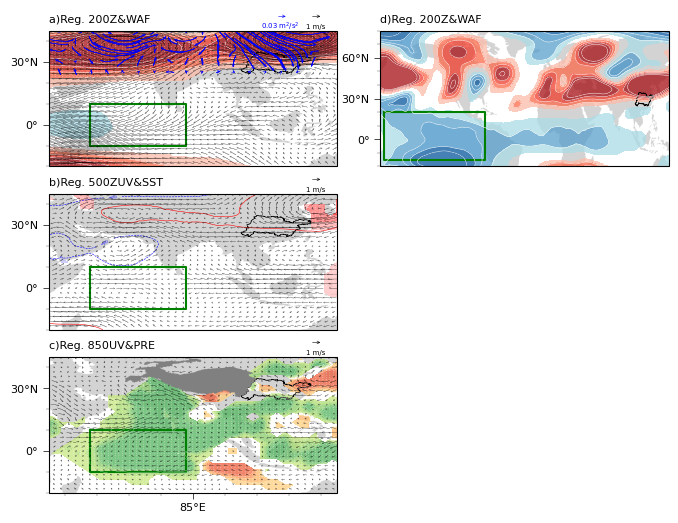

In [42]:
from toolbar.significance_test import r_test

p_th = r_test(62, 0.1) # 62为样本量，0.1为显著性水平
# 绘图
if 1:
    fig = plt.figure(figsize=(8, 6))
    fig.subplots_adjust(hspace=0.4)  # Increase vertical spacing between subplots
    xticks1 = np.arange(draw_zone_1[0], draw_zone_1[1], 10)
    yticks1 = np.arange(draw_zone_1[2], draw_zone_1[3], 30)
    #子图间距
    gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1], wspace=0.15, hspace=0.2)
    plt.subplots_adjust(wspace=0.1, hspace=0.05)
    ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
    ax1.set_title(f"a)Reg. 200Z&WAF", fontsize=8, loc='left')
    ax1.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax1.set_aspect('auto')
    ax1.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax1.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    rec(ax1, zone_1, color='green')
    latlon_fmt(ax1, None, yticks1, MultipleLocator(60), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # 3Dwaf
    Uc = xr.DataArray(U['u'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    Vc = xr.DataArray(V['v'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', V['lat'].data),
                                ('lon', V['lon'].data)])
    Tc = xr.DataArray(T['t'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', T['lat'].data),
                                ('lon', T['lon'].data)])
    GEOa = xr.DataArray(reg_z_1[1:4, :, :],
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z = TN_WAF_3D(Uc, Vc, GEOa, Tc)
    reg_z_, lon = add_cyclic_point(reg_z_1[2, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_1[2, :, :], coord=Z['lon'])
    reg_z_ = np.where((np.abs(reg_z_/9.8) < 2), np.nan, reg_z_)
    waf_contf = ax1.contourf(lon, Z['lat'], reg_z_/9.8,
                                           levels=np.array([-1, -.8, -.6, -.4, -.2, .2, .4, .6, .8, 1])*10,
                                           cmap=cmaps.temp_diff_18lev[2:-2], alpha=0.75,
                                           extend='both',
                                           transform=ccrs.PlateCarree(central_longitude=0))
    waf_cont = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=np.array([-1, -.8, -.6, -.4, -.2, .2, .4, .6, .8, 1])*10, linestyles='solid', linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    ax1.quiver(lon, Z['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    wind = Curlyquiver(ax1, U['lon'], U['lat'], reg_u_1[2, :, :], reg_v_1[2, :, :], thinning=[0.2, 'min'],
                                  center_lon=c_lon_1, arrowsize=.25, scale=15, linewidth=0.15, regrid=30,
                                   color='k')
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, linewidth=0.4,color='k')
    waf_speed = np.sqrt(waf_x[1] ** 2 + waf_y[1] ** 2)
    waf_speed_50 = np.nanpercentile(waf_speed, 20)
    waf_speed_mask = np.where(waf_speed > waf_speed_50, 1, 0)
    waf_x_mask = waf_speed_mask * waf_x[1]
    waf_y_mask = waf_speed_mask * waf_y[1]
    WAF_cq = Curlyquiver(ax1, waf_x['lon'], waf_x['lat'][:180],
                                  waf_x_mask[:180, :], waf_y_mask[:180, :], thinning=['25%', 'min'],
                                  regrid=10, center_lon=c_lon_1, arrowsize=.5, scale=7.5, linewidth=0.4,
                                  color='blue', nanmax=.2)
    WAF_cq.key(fig, U=.03, label='0.03 m$^2$/s$^2$', lr=1.8, ud=7.7, edgecolor='none', arrowsize=.5, linewidth=0.4)
    # 边框显示为黑色
    ax1.grid(False)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')

    ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
    ax2.set_title(f"b)Reg. 500ZUV&SST", fontsize=8, loc='left')
    ax2.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax2.set_aspect('auto')
    ax2.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax2.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    rec(ax2, zone_1, color='green')
    latlon_fmt(ax2, None, yticks1, MultipleLocator(60), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # z
    z_high = ax2.contour(Z['lon'], Z['lat'], reg_z_1[3, :, :], colors='red', levels=[20], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax2.contour(Z['lon'], Z['lat'], reg_z_1[3, :, :], colors='blue', levels=[-20], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=3)
    z_low.clabel(inline=1, fontsize=3)
    reg_sst_, lon = add_cyclic_point(reg_sst_1[:, :], coord=Sst['lon'])
    corr_sst_, lon = add_cyclic_point(corr_sst_1[:, :], coord=Sst['lon'])
    reg_sst_ = np.where((np.abs(reg_sst_) < .1), np.nan, reg_sst_)
    # sst
    sst = ax2.contourf(lon, Sst['lat'], reg_sst_, cmap=cmaps.GMT_polar[2:10] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10:-2], levels=[-.5, -.4, -.3, -.2, -.1, .1, .2, .3, .4, .5], extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_sst_) > p_th, 0, np.nan)
    ax2.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # wind
    wind = Curlyquiver(ax2, U['lon'], U['lat'], reg_u_1[3, :, :], reg_v_1[3, :, :], thinning=[0.1, 'min'],
                                  center_lon=c_lon_1, arrowsize=.25, scale=15, linewidth=0.15, regrid=30,
                                  color='k', nanmax=wind.nanmax)
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4)
    # 边框显示为黑色
    ax2.grid(False)
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')

    ax3 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
    ax3.set_title(f"c)Reg. 850UV&PRE", fontsize=8, loc='left')
    ax3.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax3.set_aspect('auto')
    ax3.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax3.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    rec(ax3, zone_1, color='green')
    ax3.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary_2500m\TPBoundary_2500m.shp').geometries(),
                                   ccrs.PlateCarree(), facecolor='gray', edgecolor='gray', linewidth=.1, hatch='.', zorder=10)
    latlon_fmt(ax3, xticks1, yticks1, MultipleLocator(60), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    reg_pre_, lon = add_cyclic_point(reg_pre_1[:, :], coord=Pre['lon'])
    corr_pre_, lon = add_cyclic_point(corr_pre_1[:, :], coord=Pre['lon'])
    reg_pre_ = np.where((np.abs(reg_pre_) < .1), np.nan, reg_pre_)
    # pre
    pre = ax3.contourf(lon, Pre['lat'], reg_pre_, cmap=cmaps.MPL_RdYlGn[22+0:56] + cmaps.CBR_wet[0] + cmaps.MPL_RdYlGn[72:106-0], alpha=0.75, levels=[-.5, -.4, -.3, -.2, -.1, .1, .2, .3, .4, .5], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    pre_edge = ax3.contour(lon, Pre['lat'], reg_pre_, colors='white', levels=[-.5, -.4, -.3, -.2,-.1, .1, .2, .3, .4, .5], linestyles='solid',linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_pre_) > p_th, 0, np.nan)
    ax3.quiver(lon, Pre['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # wind
    wind = Curlyquiver(ax3, U['lon'], U['lat'], reg_u_1[4, :, :], reg_v_1[4, :, :], thinning=[0.1, 'min'],
                                  center_lon=c_lon_1, arrowsize=.25, scale=15, linewidth=0.15, regrid=30,
                                color='k', nanmax=wind.nanmax)
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4)
    # 边框显示为黑色
    ax3.grid(False)
    for spine in ax3.spines.values():
        spine.set_edgecolor('black')

    ax4, ax5, ax6 = ax1, ax2, ax3

    ################################################################右图
    xticks1 = np.arange(draw_zone_2[0], draw_zone_2[1], 10)
    yticks1 = np.arange(draw_zone_2[2], draw_zone_2[3], 30)
    ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
    ax1.set_title(f"d)Reg. 200Z&WAF", fontsize=8, loc='left')
    ax1.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax1.set_aspect('auto')
    ax1.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax1.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    rec(ax1, zone_2, color='green')
    latlon_fmt(ax1, None, yticks1, MultipleLocator(60), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # 3Dwaf
    Uc = xr.DataArray(U['u'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    Vc = xr.DataArray(V['v'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', V['lat'].data),
                                ('lon', V['lon'].data)])
    Tc = xr.DataArray(T['t'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', T['lat'].data),
                                ('lon', T['lon'].data)])
    GEOa = xr.DataArray(reg_z_2[1:4, :, :],
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z = TN_WAF_3D(Uc, Vc, GEOa, Tc)
    reg_z_, lon = add_cyclic_point(reg_z_2[2, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_2[2, :, :], coord=Z['lon'])
    reg_z_ = np.where((np.abs(reg_z_/9.8) < 2), np.nan, reg_z_)
    waf_contf = ax1.contourf(lon, Z['lat'], reg_z_/9.8,
                                           levels=np.array([-1, -.8, -.6, -.4, -.2, .2, .4, .6, .8, 1])*10,
                                           cmap=cmaps.temp_diff_18lev[2:-2], alpha=0.75,
                                           extend='both',
                                           transform=ccrs.PlateCarree(central_longitude=0))
    waf_cont = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=np.array([-1, -.8, -.6, -.4, -.2, .2, .4, .6, .8, 1])*10, linestyles='solid', linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    ax1.quiver(lon, Z['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    wind = Curlyquiver(ax1, U['lon'], U['lat'], reg_u_2[2, :, :], reg_v_2[2, :, :], thinning=[0.2, 'min'],
                                  center_lon=c_lon_2, arrowsize=.25, scale=15, linewidth=0.15, regrid=30,
                                   color='k', nanmax=wind.nanmax)
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4)
    waf_speed = np.sqrt(waf_x[1] ** 2 + waf_y[1] ** 2)
    waf_speed_50 = np.nanpercentile(waf_speed, 20)
    waf_speed_mask = np.where(waf_speed > waf_speed_50, 1, 0)
    waf_x_mask = waf_speed_mask * waf_x[1]
    waf_y_mask = waf_speed_mask * waf_y[1]
    WAF_cq = Curlyquiver(ax1, waf_x['lon'], waf_x['lat'][:180],
                                  waf_x_mask[:180, :], waf_y_mask[:180, :], thinning=['25%', 'min'],
                                  regrid=10, center_lon=c_lon_2, arrowsize=.5, scale=7.5, linewidth=0.4,
                                  color='blue', nanmax=.2)
    WAF_cq.key(fig, U=.03, label='0.03 m$^2$/s$^2$', lr=1.8, ud=7.7, edgecolor='none', arrowsize=.5, linewidth=0.4)
    # 边框显示为黑色
    ax1.grid(False)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
    # 色标
    ax1_colorbar = inset_axes(ax1, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax1.transAxes, borderpad=0)
    cb1 = plt.colorbar(waf_contf, cax=ax1_colorbar, orientation='vertical', drawedges=True)
    cb1.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb1.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb1.locator = ticker.FixedLocator(np.array([-1, -.8, -.6, -.4, -.2, .2, .4, .6, .8, 1])*10)
    #cb1.set_ticklabels(['-30', '-25', '-20', '-15', '-10', '-5', '5', '10', '15', '20', '25', '30'])
    cb1.ax.tick_params(length=0, labelsize=6)  # length为刻度线的长度

    ax2 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
    ax2.set_title(f"e)Reg. 500ZUV&SST", fontsize=8, loc='left')
    ax2.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax2.set_aspect('auto')
    ax2.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax2.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    rec(ax2, zone_2, color='green')
    latlon_fmt(ax2, None, yticks1, MultipleLocator(60), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # z
    z_high = ax2.contour(Z['lon'], Z['lat'], reg_z_2[3, :, :], colors='red', levels=[20], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax2.contour(Z['lon'], Z['lat'], reg_z_2[3, :, :], colors='blue', levels=[-20], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=3)
    z_low.clabel(inline=1, fontsize=3)
    reg_sst_, lon = add_cyclic_point(reg_sst_2[:, :], coord=Sst['lon'])
    corr_sst_, lon = add_cyclic_point(corr_sst_2[:, :], coord=Sst['lon'])
    reg_sst_ = np.where((np.abs(reg_sst_) < .1), np.nan, reg_sst_)
    # sst
    sst = ax2.contourf(lon, Sst['lat'], reg_sst_, cmap=cmaps.GMT_polar[2:10] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10:-2], levels=[-.5, -.4, -.3, -.2, -.1, .1, .2, .3, .4, .5], extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_sst_) > p_th, 0, np.nan)
    ax2.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # wind
    wind = Curlyquiver(ax2, U['lon'], U['lat'], reg_u_2[3, :, :], reg_v_2[3, :, :], thinning=[0.1, 'min'],
                                  center_lon=c_lon_2, arrowsize=.25, scale=15, linewidth=0.15, regrid=30,
                                  color='k', nanmax=wind.nanmax)
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4)
    # 边框显示为黑色
    ax2.grid(False)
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')
    # 色条
    ax2_colorbar = inset_axes(ax2, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
    cb2 = plt.colorbar(sst, cax=ax2_colorbar, orientation='vertical', drawedges=True)
    cb2.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb2.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb2.ax.tick_params(length=0, labelsize=6)  # length为刻度线的长度

    ax3 = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
    ax3.set_title(f"f)Reg. 850UV&PRE", fontsize=8, loc='left')
    ax3.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax3.set_aspect('auto')
    ax3.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax3.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    rec(ax3, zone_2, color='green')
    ax3.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary_2500m\TPBoundary_2500m.shp').geometries(),
                                   ccrs.PlateCarree(), facecolor='gray', edgecolor='gray', linewidth=.1, hatch='.', zorder=10)
    latlon_fmt(ax3, xticks1, yticks1, MultipleLocator(60), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    reg_pre_, lon = add_cyclic_point(reg_pre_2[:, :], coord=Pre['lon'])
    corr_pre_, lon = add_cyclic_point(corr_pre_2[:, :], coord=Pre['lon'])
    reg_pre_ = np.where((np.abs(reg_pre_) < .1), np.nan, reg_pre_)
    # pre
    pre = ax3.contourf(lon, Pre['lat'], reg_pre_, cmap=cmaps.MPL_RdYlGn[22+0:56] + cmaps.CBR_wet[0] + cmaps.MPL_RdYlGn[72:106-0], alpha=0.75, levels=[-.5, -.4, -.3, -.2, -.1, .1, .2, .3, .4, .5], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    pre_edge = ax3.contour(lon, Pre['lat'], reg_pre_, colors='white', levels=[-.5, -.4, -.3, -.2,-.1, .1, .2, .3, .4, .5], linestyles='solid',linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_pre_) > p_th, 0, np.nan)
    ax3.quiver(lon, Pre['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # wind
    wind = Curlyquiver(ax3, U['lon'], U['lat'], reg_u_2[4, :, :], reg_v_2[4, :, :], thinning=[0.1, 'min'],
                                  center_lon=c_lon_2, arrowsize=.25, scale=15, linewidth=0.15, regrid=30,
                                color='k', nanmax=wind.nanmax)
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4)
    # 边框显示为黑色
    ax3.grid(False)
    for spine in ax3.spines.values():
        spine.set_edgecolor('black')
    # 色条
    ax3_colorbar = inset_axes(ax3, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax3.transAxes, borderpad=0)
    cb3 = plt.colorbar(pre, cax=ax3_colorbar, orientation='vertical', drawedges=True)
    cb3.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb3.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb3.locator = ticker.FixedLocator(np.array([-.5, -.4, -.3, -.2,-.1, .1,.2,.3,.4,.5]))
    cb3.set_ticklabels(['-0.5', '-0.4', '-0.3', '-0.2', '-0.1', '0.1', '0.2', '0.3', '0.4', '0.5'])
    cb3.ax.tick_params(length=0, labelsize=6)  # length为刻度线的长度


    plt.savefig(f'D:/PyFile/p2/pic/回归场.png', dpi=600, bbox_inches='tight')
    plt.show()
